In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import Tuple
from simple_tracking import CenterlineInferringAgent

from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import OdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

2024-12-23 07:21:04.528700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 07:21:04.539545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 07:21:04.542924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 07:21:05.190119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [76]:
# class OdorPredictor:
#     def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
#         self.fitted_p_heatmap = fitted_p_heatmap
#         self.xedges = xedges
#         self.yedges = yedges
#         self.distance_threshold = distance_threshold
#         self.rows_per_second = rows_per_second
#         self.base_odor_level = base_odor_level
#         self.initialize_data(fdf, fdf_nowhiff)

#     def initialize_data(self, fdf, fdf_nowhiff):
#         # Extract necessary data as arrays for faster access
#         self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
#         self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
#         self.whiff_means = fdf.mean_concentration.values
#         self.whiff_stds = fdf.std_whiff.values
#         self.whiff_duration = fdf.length_of_encounter.values
#         self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
#         self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

#     def predict_whiff_from_probability(self, x, y):
#         x_bin = np.digitize(x, self.xedges) - 1
#         y_bin = np.digitize(y, self.yedges) - 1
#         if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
#             return False, 0
#         whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
#         return np.random.rand() < whiff_prob, whiff_prob

#     @staticmethod
#     def moving_average(data, window_size=5):
#         # Adjust moving average to keep the same length as input data
#         return np.convolve(data, np.ones(window_size)/window_size, mode='same')

#     def predict_odor_concentration(self, x, y):
#         # Convert DataFrame columns to NumPy arrays
#         df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
#         odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
#         whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

#         test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
#         distances = cdist(test_locations, self.whiff_locations)
#         distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

#         # Process whiff and no-whiff regions
#         odor_concentration_samples, whiff_prediction_samples = self.process_whiff_regions(
#             distances, odor_concentration_samples, whiff_prediction_samples, test_locations
#         )
#         odor_concentration_samples = self.process_no_whiff_regions(
#             distances_nowhiff, odor_concentration_samples
#         )

#         # Return results as DataFrame
#         df_test['predicted_odor'] = odor_concentration_samples
#         df_test['whiff_predicted'] = whiff_prediction_samples
#         return df_test

#     def process_whiff_regions(self, distances, odor_concentration_samples, whiff_prediction_samples, test_locations):
#         for i, (dist_along, nearest_from) in enumerate(test_locations):
#             whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
#             if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
#                 nearest_whiff_idx = np.argmin(distances[i])
#                 mean_concentration = self.whiff_means[nearest_whiff_idx]
#                 std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
#                 duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
#                 rows_to_fill = min(duration, len(odor_concentration_samples) - i)

#                 generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#                 generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
#                 odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#                 whiff_prediction_samples[i:i + rows_to_fill] = 1
#         return odor_concentration_samples, whiff_prediction_samples

#     def process_no_whiff_regions(self, distances_nowhiff, odor_concentration_samples):
#         i = 0
#         while i < len(odor_concentration_samples):
#             if odor_concentration_samples[i] == self.base_odor_level:
#                 nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#                 no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
#                 no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

#                 start = i
#                 while i < len(odor_concentration_samples) and odor_concentration_samples[i] == self.base_odor_level:
#                     i += 1
#                 end = i

#                 no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#                 no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
                
#                 # Check if moving average should be applied
#                 if end - start >= 5:  # Apply only if length >= window size
#                     smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)
#                     odor_concentration_samples[start:end] = smoothed_concentrations[:end - start]
#                 else:
#                     odor_concentration_samples[start:end] = no_whiff_concentrations
#             else:
#                 i += 1
#         return odor_concentration_samples

# if __name__ == "__main__":

#     dirname = '../data/simulator/hws/'
#     hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
#     predictor = OdorPredictor(
#         fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
#         xedges=hmap_data['xedges'],
#         yedges=hmap_data['yedges'],
#         fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
#         fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
#     )
    
#     df = pd.read_hdf(str(dirname) + 'hwsDesert.h5')
#     df_test = df[10000:].reset_index(drop=True)
#     x = df_test.distance_along_streakline.values
#     y = df_test.nearest_from_streakline.values
    
#     pdf = predictor.predict_odor_concentration(x, y)

In [88]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from typing import Tuple, Dict

@dataclass
class OdorConfig:
    rows_per_second: int = 200
    base_odor_level: float = 0.70
    distance_threshold: float = 3
    ar1: float = 0.98
    ar2: float = -0.02
    warmup_steps: int = 1000
    low_threshold: float = 0.05
    history_length: int = 7
    transition_matrix: np.ndarray = np.array([[0.15, 0.85], [0.15, 0.85]])

class OdorStateManager:
    def __init__(self, config: OdorConfig, whiff_intermittency: np.ndarray):
        self.recent_history = [0] * 1000
        self.recent_concentrations = [config.base_odor_level] * 10
        self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 5))
        self.current_concentration = config.base_odor_level
        self.prev_concentration = config.base_odor_level
        self.in_whiff_state = False
        self.state_duration = 0

class SimpleOdorPredictor:
    def __init__(self, fitted_p_heatmap: np.ndarray, xedges: np.ndarray, 
                 yedges: np.ndarray, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        """
        Initialize the predictor with heatmap data and whiff/no-whiff information.
        """
        self.config = OdorConfig()
        self.fitted_p_heatmap = fitted_p_heatmap
        self.xedges = xedges
        self.yedges = yedges
        self.setup_data(fdf, fdf_nowhiff)

    def setup_data(self, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        """Initialize data arrays and distance bins."""
        self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.whiff_means = fdf.mean_concentration.values
        self.whiff_stds = fdf.std_whiff.values
        self.whiff_duration = fdf.length_of_encounter.values
        self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
        self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values
        self.whiff_intermittency = fdf.odor_intermittency.values

        # Setup distance bins for intermittency
        distance_bins = np.arange(0, 60, 15)
        self.bin_data_dict = {}
        for i in range(len(distance_bins)-1):
            start_dist, end_dist = distance_bins[i], distance_bins[i+1]
            bin_data = fdf[
                (fdf['avg_distance_along_streakline'] >= start_dist) &
                (fdf['avg_distance_along_streakline'] < end_dist)
            ]['odor_intermittency'].dropna().values
            self.bin_data_dict[(start_dist, end_dist)] = bin_data

    def get_spatial_probability(self, x: float, y: float) -> float:
        """Calculate spatial probability from heatmap for given coordinates."""
        x_bin = np.digitize(x, self.xedges) - 1
        y_bin = np.digitize(y, self.yedges) - 1
        
        if (x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or 
            y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]):
            return 0.0
            
        return self.fitted_p_heatmap[x_bin, y_bin]

    def generate_intermittency(self, distance: float, state: OdorStateManager, default: float = 0.05) -> float:
        """Generate intermittency value based on distance and state."""
        last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
        low_frequency = np.mean(last_values < self.config.low_threshold)
        
        for (sd, ed), values in self.bin_data_dict.items():
            if sd <= distance < ed and len(values) > 0:
                if low_frequency > 0.5:
                    median_val = np.median(values)
                    subset = values[values < median_val]
                    if len(subset) > 0:
                        intermittency = np.random.choice(subset)
                    else:
                        intermittency = np.random.choice(values)
                else:
                    intermittency = np.random.choice(values)
                return np.clip(intermittency, np.min(values), np.max(values))
        return default

    def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
        """Update whiff state posterior probability."""
        whiff_state = 1 if state.in_whiff_state else 0
        num_recent_whiffs = sum(state.recent_history[-20:])
        
        time_since_whiff = 0
        for i in range(len(state.recent_history)-1, -1, -1):
            if state.recent_history[i]:
                break
            time_since_whiff += 1
        
        time_factor = min(1.5, time_since_whiff / 35) if time_since_whiff > 50 else 1.0
        boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor
        
        recent_avg_concentration = np.mean(state.recent_concentrations[-10:])
        ar_factor = max(0, (recent_avg_concentration - self.config.base_odor_level) / 
                       (4.5 - self.config.base_odor_level))
        concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)
        
        posterior = ((prior_prob * 0.2) * self.config.transition_matrix[whiff_state][1] * 
                    boost_factor * concentration_factor)
        return posterior / (posterior + (1 - posterior))


    def update_ar2_concentration(self, current: float, prev: float, target: float, 
                               noise_scale: float) -> float:
        """Update concentration using AR(2) model."""
        noise = noise_scale * (np.random.randn() - 0.5) * 0.5
        x_next = (0.85 * (self.config.ar1 * (current - target) + 
                 self.config.ar2 * (prev - target)) + target + noise)
        return x_next

    def predict_odor_concentration(self, x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
        """
        Predict odor concentrations for given coordinates.
        
        Args:
            x: Array of x coordinates
            y: Array of y coordinates
            
        Returns:
            DataFrame with predicted odor concentrations and whiff predictions
        """
        # Convert to numpy arrays if needed
        if isinstance(x, pd.Series):
            x = x.values
        if isinstance(y, pd.Series):
            y = y.values

        # Create DataFrame
        df_result = pd.DataFrame({
            'distance_along_streakline': x,
            'nearest_from_streakline': y
        })
        
        # Process data in sequential segments
        segment_size = 2000
        total_segments = len(x) // segment_size + (1 if len(x) % segment_size else 0)
        
        all_concentrations = []
        all_predictions = []
        
        # Initialize state
        state = OdorStateManager(self.config, self.whiff_intermittency)
        
        for seg_idx in range(total_segments):
            start_idx = seg_idx * segment_size
            end_idx = min((seg_idx + 1) * segment_size, len(x))
            
            # Get segment data
            segment_x = x[start_idx:end_idx]
            segment_y = y[start_idx:end_idx]
            segment_locations = np.column_stack((segment_x, segment_y))
            
            # Calculate distances for this segment
            distances = cdist(segment_locations, self.whiff_locations)
            distances_nowhiff = cdist(segment_locations, self.nowhiff_locations)
            
            # Initialize segment arrays
            concentrations = np.full(len(segment_x), self.config.base_odor_level)
            predictions = np.zeros(len(segment_x), dtype=int)
            
            i = 0
            while i < len(segment_x):
                if start_idx + i < self.config.warmup_steps:
                    i += 1
                    continue

                spatial_prob = self.get_spatial_probability(segment_x[i], segment_y[i])
                posterior = self.update_whiff_posterior(spatial_prob, state)

                # Update whiff state
                if state.in_whiff_state:
                    state.state_duration += 1
                    min_duration = 0.1 * self.config.rows_per_second
                    if state.state_duration > min_duration:
                        continue_prob = 0.5 * spatial_prob
                        state.in_whiff_state = np.random.rand() < continue_prob
                else:
                    concentration_factor = ((state.current_concentration - self.config.base_odor_level) / 
                                         (4.5 - self.config.base_odor_level))
                    transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
                    state.in_whiff_state = np.random.rand() < transition_prob * 0.5
                    if state.in_whiff_state:
                        state.state_duration = 0

                if state.in_whiff_state and np.min(distances[i]) <= self.config.distance_threshold:
                    # Process whiff state
                    nearest_idx = np.argmin(distances[i])
                    mean_concentration = self.whiff_means[nearest_idx]
                    std_dev_whiff = self.whiff_stds[nearest_idx]
                    duration = int(self.whiff_duration[nearest_idx] * self.config.rows_per_second)
                    rows_to_fill = min(duration, len(segment_x) - i)

                    for j in range(rows_to_fill):
                        new_concentration = self.update_ar2_concentration(
                            state.current_concentration,
                            state.prev_concentration,
                            mean_concentration,
                            0.15 * std_dev_whiff
                        )
                        new_concentration = np.clip(new_concentration, 4.5, 10.2)
                        
                        state.prev_concentration = state.current_concentration
                        state.current_concentration = new_concentration
                        
                        concentrations[i + j] = new_concentration
                        predictions[i + j] = 1
                        
                        state.recent_concentrations.append(new_concentration)
                        state.recent_concentrations.pop(0)
                        state.recent_history.append(1)
                        state.recent_history.pop(0)

                    i += rows_to_fill
                    
                    # Handle intermittency
                    if i < len(segment_x):
                        intermittency = self.generate_intermittency(segment_x[i-1], state)
                        state.recent_intermittencies.append(intermittency)
                        state.recent_intermittencies.pop(0)
                        
                        intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
                        i += intermittency_duration
                else:
                    # Process no-whiff state
                    nearest_idx = np.argmin(distances_nowhiff[i])
                    no_whiff_mean = self.nowhiff_means[nearest_idx]
                    no_whiff_std = self.nowhiff_wsd[nearest_idx]
                    
                    new_concentration = self.update_ar2_concentration(
                        state.current_concentration,
                        state.prev_concentration,
                        no_whiff_mean,
                        0.05 * no_whiff_std
                    )
                    new_concentration = np.clip(new_concentration, 0.7, 1.0)
                    
                    if i >= 10:
                        window_data = concentrations[i-10:i]
                        window_data = np.append(window_data, new_concentration)
                        window = np.ones(10)/10.0
                        new_concentration = np.convolve(window_data, window, mode='valid')[-1]
                    
                    state.prev_concentration = state.current_concentration
                    state.current_concentration = new_concentration
                    
                    concentrations[i] = new_concentration
                    state.recent_concentrations.append(new_concentration)
                    state.recent_concentrations.pop(0)
                    state.recent_history.append(0)
                    state.recent_history.pop(0)
                    
                    i += 1
            
            all_concentrations.append(concentrations)
            all_predictions.append(predictions)

        # Combine results
        final_concentrations = np.concatenate(all_concentrations)
        final_predictions = np.concatenate(all_predictions)
        
        # Apply final smoothing
        final_concentrations = gaussian_filter(final_concentrations, sigma=0.8)
        
        df_result['predicted_odor'] = final_concentrations
        df_result['whiff_predicted'] = final_predictions
        
        return df_result

def main(dirname: str, x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    """Example usage of SimpleOdorPredictor"""
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')
    
    predictor = SimpleOdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )
    
    return predictor.predict_odor_concentration(x, y)

In [89]:
if __name__ == "__main__":
    dirname = '../data/simulator/hws/'
    df_test = pd.read_hdf(dirname + 'hwsDesert.h5')
    df_test = df_test
    
    result = main(dirname, 
                 df_test['distance_along_streakline'],
                 df_test['nearest_from_streakline'])
    
    df_test['predicted_odor'] = result['predicted_odor']
    df_test['whiff_predicted'] = result['whiff_predicted']

In [46]:
# dirname = '../data/simulator/rigolli/'
# hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")

# fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
# xedges=hmap_data['xedges'],
# yedges=hmap_data['yedges'],
# fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
# fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')

# Plot the smoothed adjusted heatmap
# f, ax = plt.subplots(1, 1, figsize=(6, 10))
# xedges=hmap_data['xedges']
# yedges=hmap_data['yedges']
# cax = ax.imshow(
#     fitted_p_heatmap.T,
#     origin='lower',
#     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#     cmap='Blues', vmin=0, vmax=0.01
# )

# divider = make_axes_locatable(ax)
# cbar = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
# ax.set_xlabel('35 m')
# ax.set_ylabel('8 m')
# ax.set_xticklabels([''])
# ax.set_yticklabels([''])
# f.tight_layout()

In [47]:
# def growing_sine_wave_from_point(x_start, y_start, start_amplitude, start_wavelength, duration=10, num_points=100, amplitude_growth_rate=0.1, wavelength_growth_rate=0.05):
#     """Generate a growing sinusoidal trajectory."""
#     time = np.linspace(x_start, x_start - duration, num_points)  # Move toward 0
#     amplitude = start_amplitude + amplitude_growth_rate * (x_start - time)  # Grow amplitude
#     wavelength = start_wavelength + wavelength_growth_rate * (x_start - time)  # Grow wavelength
#     frequency = 1 / wavelength
#     sine_wave = amplitude * np.sin(2 * np.pi * frequency * (x_start - time)) + y_start

#     return time, sine_wave, amplitude[-1], wavelength[-1]


# def plot_trajectory(all_time, all_sine_wave, detected_times, detected_sine_waves, source):
#     """Visualizes the agent's trajectory."""
#     f,ax = plt.subplots(figsize=(6, 4))
#     ax.plot(all_time, all_sine_wave, label='Agent Trajectory', color='black')
#     ax.scatter(detected_times, detected_sine_waves, color='red', label='Odor Detected', zorder=5)
#     ax.scatter(source[0], source[1], color='blue', label='Source', s=100, zorder=10)
#     ax.set_xlabel("Distance along streakline, m")
#     ax.set_ylabel("Nearest from streakline")
#     ax.legend()
#     ax.grid(False)
#     f.tight_layout()


# def trajectory_to_targets(x_start, y_start, source, simulator, threshold, radius=1, duration=10, num_points=200, 
#                           amplitude_growth_rate=0.1, wavelength_growth_rate=0.05, max_steps=100):
#     """
#     Implements the cast-and-surge behavior for the agent with proper distance-based stopping at (0, 0).
#     """
#     # Initialize variables
#     current_x, current_y = x_start, y_start
#     all_time, all_sine_wave = [], []
#     detected_times, detected_sine_waves = [], []
#     odor_series, time_series = [], []  # Store continuous odor concentrations and time
#     last_amplitude, last_wavelength = 1, 1  # Initial amplitude and wavelength
#     step_count = 0
#     is_surging = False
#     current_time = 0  # Start time counter
#     time_step = 0.1  # Fixed time increment per step

#     while step_count < max_steps:
#         if is_surging:
#             # Surge phase: Move straight along the x-axis
#             surge_distance = 5  # Maximum distance to move
#             surge_steps = int(surge_distance / time_step)
#             surge_time = np.linspace(current_x, max(current_x - surge_distance, source[0]), surge_steps)
#             surge_wave = np.full_like(surge_time, current_y)  # Keep y constant

#             # Predict odor and store results
#             predicted_data = simulator.predict_odor_concentration(surge_time, surge_wave)
#             odor_series.extend(predicted_data['predicted_odor'])
#             time_series.extend([current_time + i * time_step for i in range(len(surge_time))])

#             # Update the time counter continuously
#             current_time += time_step * len(surge_time)

#             # Check for termination or odor detection
#             for idx, (x, y) in enumerate(zip(surge_time, surge_wave)):
#                 distance_to_source = np.sqrt((x - source[0])**2 + (y - source[1])**2)
#                 if distance_to_source < radius:
#                     print(f"Source reached at ({x:.2f}, {y:.2f}). Stopping.")
#                     all_time.extend(surge_time[:idx + 1])
#                     all_sine_wave.extend(surge_wave[:idx + 1])
#                     return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series

#             detected_indices = np.where(predicted_data['predicted_odor'] >= threshold)[0]
#             if len(detected_indices) > 0:
#                 first_detection_idx = detected_indices[0]
#                 detected_x = surge_time[first_detection_idx]
#                 detected_y = surge_wave[first_detection_idx]

#                 # Update trajectory and position
#                 current_x, current_y = detected_x, detected_y
#                 all_time.extend(surge_time[:first_detection_idx + 1])
#                 all_sine_wave.extend(surge_wave[:first_detection_idx + 1])
#                 print(f"Odor detected during surge at ({detected_x:.2f}, {detected_y:.2f}). Continuing surge.")
#                 continue

#             # No odor detected: Update position
#             all_time.extend(surge_time)
#             all_sine_wave.extend(surge_wave)
#             current_x, current_y = surge_time[-1], surge_wave[-1]
#             is_surging = False

#         else:
#             # Casting phase: Generate sinusoidal trajectory
#             temp_time, temp_sine_wave, last_amplitude, last_wavelength = growing_sine_wave_from_point(
#                 current_x, current_y, last_amplitude, last_wavelength, duration, num_points, amplitude_growth_rate, wavelength_growth_rate
#             )

#             # Predict odor and store results
#             predicted_data = simulator.predict_odor_concentration(temp_time, temp_sine_wave)
#             odor_series.extend(predicted_data['predicted_odor'])
#             time_series.extend([current_time + i * time_step for i in range(len(temp_time))])

#             # Update the time counter continuously
#             current_time += time_step * len(temp_time)

#             # Check for termination or odor detection
#             for idx, (x, y) in enumerate(zip(temp_time, temp_sine_wave)):
#                 distance_to_source = np.sqrt((x - source[0])**2 + (y - source[1])**2)
#                 if distance_to_source < radius:
#                     print(f"Source reached at ({x:.2f}, {y:.2f}). Stopping.")
#                     all_time.extend(temp_time[:idx + 1])
#                     all_sine_wave.extend(temp_sine_wave[:idx + 1])
#                     return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series

#             detected_indices = np.where(predicted_data['predicted_odor'] >= threshold)[0]
#             if len(detected_indices) > 0:
#                 first_detection_idx = detected_indices[0]
#                 detected_x = temp_time[first_detection_idx]
#                 detected_y = temp_sine_wave[first_detection_idx]

#                 # Update trajectory and position
#                 current_x, current_y = detected_x, detected_y
#                 all_time.extend(temp_time[:first_detection_idx + 1])
#                 all_sine_wave.extend(temp_sine_wave[:first_detection_idx + 1])
#                 detected_times.append(detected_x)
#                 detected_sine_waves.append(detected_y)
#                 print(f"Odor detected during casting at ({detected_x:.2f}, {detected_y:.2f}). Switching to surge phase.")
#                 is_surging = True
#                 continue

#             # No odor detected: Update position
#             all_time.extend(temp_time)
#             all_sine_wave.extend(temp_sine_wave)
#             current_x, current_y = temp_time[-1], temp_sine_wave[-1]

#         # Increment step count
#         step_count += 1

#     return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series


In [48]:
# # Parameters for the simulation
# x_start, y_start = 50, 15  # Starting position
# source = (0, 0)           # Source position
# threshold = 4.5           # Odor detection threshold
# radius = 0.5                # Detection radius
# duration = 10             # Casting duration
# num_points = 10000          # Points per trajectory segment
# max_steps = 50            # Maximum number of iterations

# # Run the cast-and-surge algorithm
# all_time, all_sine_wave, detected_times, detected_sine_waves, time_counter, odor_series, = trajectory_to_targets(
#     x_start, y_start, source, predictor, threshold, radius, duration, num_points, max_steps=max_steps
# )
# # Plot the trajectory
# plot_trajectory(all_time, all_sine_wave, detected_times, detected_sine_waves, source)


In [49]:
# df_test['predicted_odor']=pdf.predicted_odor
# df_test['whiff_predicted']=pdf.whiff_predicted

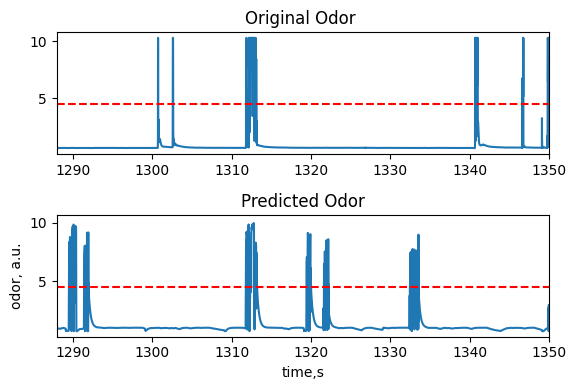

In [90]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
ax1.axhline(4.5, color = 'r', linestyle = '--')
ax2.axhline(4.5, color = 'r', linestyle = '--')
limit = (1288,1350)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor ')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [91]:
th=4.5
query1 = 'odor>'+str(th)
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+str(th)
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

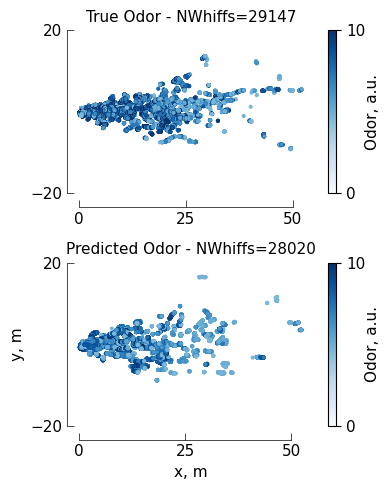

In [92]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)

cb1.set_label('Odor, a.u.',labelpad=0)
cb2.set_label('Odor, a.u.',labelpad=0)


cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    # mpl_functions.adjust_spines(ax[i],['left','bottom'],
    #                         spine_locations={'left': 1}, 
    #                         smart_bounds=True,
    #                         xticks=[0,25,50],
    #                         yticks=[0,8],
    #                         linewidth=0.5)
    # mpl_functions.set_fontsize(ax[i],11)
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-20,20],
                        linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

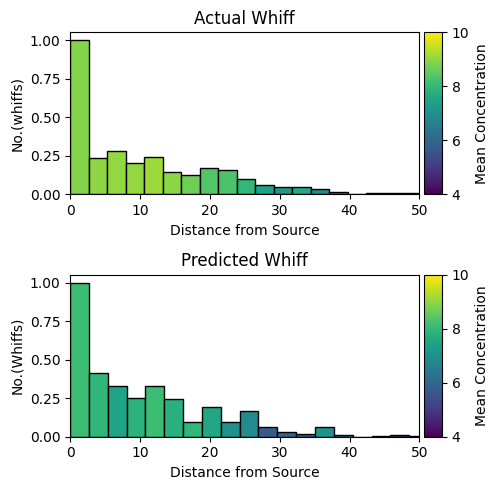

In [72]:
# Number of bins and plot limits
n_bins = 20
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts
whiff_counts_actual_normalized = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_normalized = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_normalized, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('No.(whiffs)')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(ylim)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_normalized, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_ylabel('No.(Whiffs)')
ax[1].set_title('Predicted Whiff')
ylim = (0, 1)
# ax[1].set_ylim(ylim)
ax[1].set_xlim(0, 50)

# Adjust the layout
f.tight_layout()



In [73]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

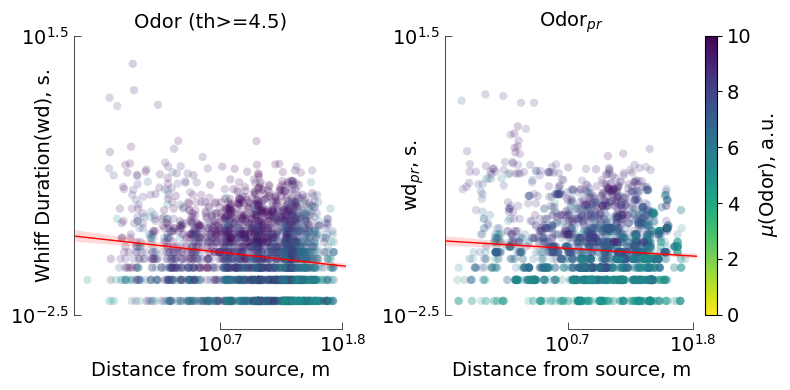

In [74]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9020.40it/s]


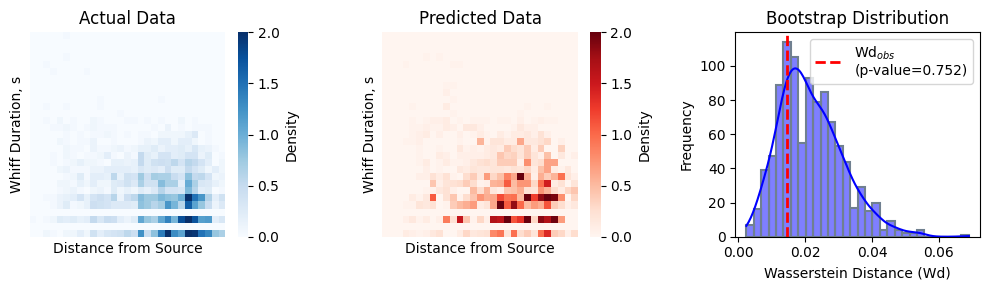

In [75]:
## Duration:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'Whiff Duration, s', 0,2)

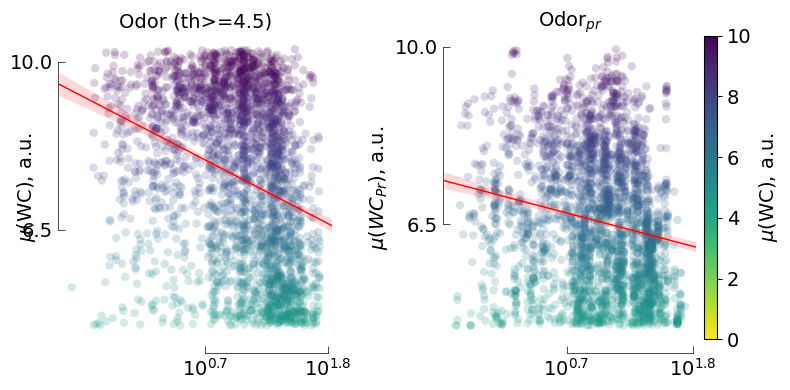

In [76]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)

# Set custom tick labels
# ax1.set_yticklabels([r'$4$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$4$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9276.99it/s]


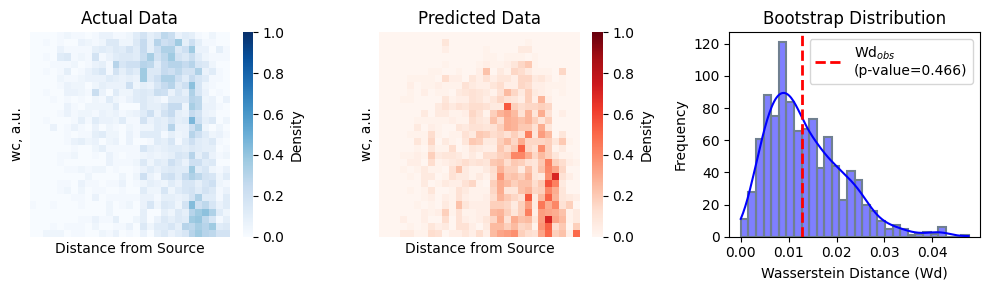

In [77]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.',0,1)

100%|██████████| 1000/1000 [00:00<00:00, 8443.24it/s]


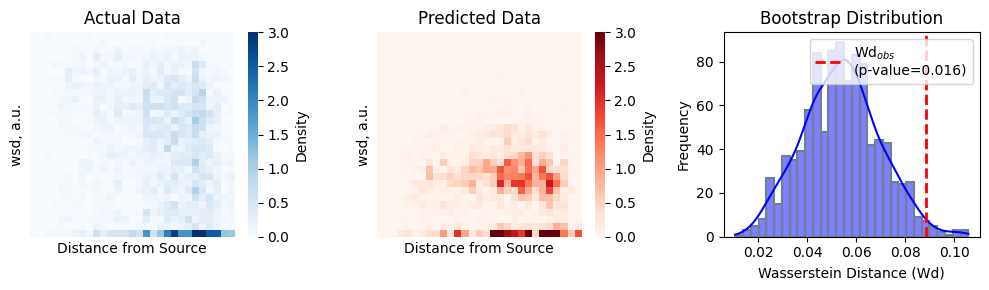

In [78]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,3)

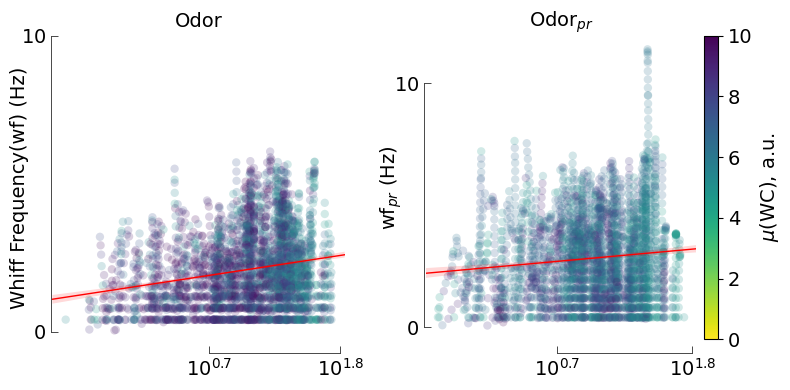

In [79]:
### WHIFF FREQUENCY
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0,12],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0, 12],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

100%|██████████| 1000/1000 [00:00<00:00, 10186.70it/s]


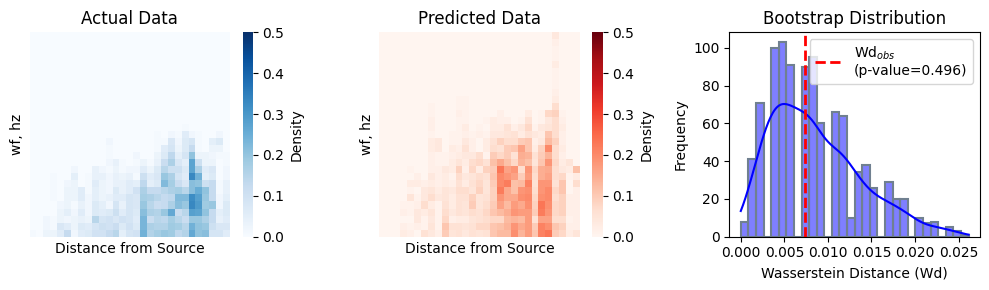

In [80]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz',0,0.5)

100%|██████████| 1000/1000 [00:00<00:00, 10148.70it/s]


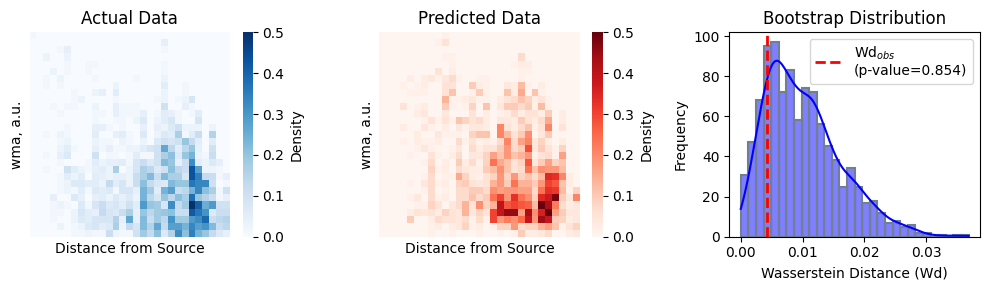

In [81]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,0.5)